In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import heapq

In [ ]:
class PriorityQueue:
    def __init__(self):
        self.elements = []

    def empty(self):
        return len(self.elements) == 0

    def put(self, item, priority):
        heapq.heappush(self.elements, (priority, item))

    def get(self):
        return heapq.heappop(self.elements)[1]

class Node:
    def __init__(self, state, parent=None, action=None, path_cost=0):
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost
    def __lt__(self, other):
        return self.path_cost < other.path_cost

def heuristic(a, b):
    (x1, y1) = a
    (x2, y2) = b
    return abs(x1 - x2) + abs(y1 - y2)

class Environment:
    def __init__(self, grid, initial, goal):
        self.grid = grid
        self.initial = initial
        self.goal = goal
        self.recharge_count = 0

    def actions(self, state):
        possible_actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
        x, y = state

        if x == 0 or self.grid[x - 1][y] == 1:
            possible_actions.remove('UP')
        if x == len(self.grid) - 1 or self.grid[x + 1][y] == 1:
            possible_actions.remove('DOWN')
        if y == 0 or self.grid[x][y - 1] == 1:
            possible_actions.remove('LEFT')
        if y == len(self.grid[0]) - 1 or self.grid[x][y + 1] == 1:
            possible_actions.remove('RIGHT')

        return possible_actions

    def result(self, state, action):
        x, y = state

        if action == 'UP':
            new_state = (x - 1, y)
        elif action == 'DOWN':
            new_state = (x + 1, y)
        elif action == 'LEFT':
            new_state = (x, y - 1)
        elif action == 'RIGHT':
            new_state = (x, y + 1)

        # Consider battery level update and recharging
        return new_state

    def is_goal(self, state):
        return state == self.goal

    def get_recharge_count(self):
        return self.recharge_count

class Agent:
    def __init__(self, env):
        self.env = env
        self.explored_paths = []

    def uniform_cost_search(self):
        frontier = PriorityQueue()
        frontier.put(Node(self.env.initial, path_cost=0), 0)
        came_from = {self.env.initial: None}
        cost_so_far = {self.env.initial: 0}
        explored_paths = []

        while not frontier.empty():
            current_node = frontier.get()

            if self.env.is_goal(current_node.state):
                return self.reconstruct_path(came_from, current_node.state), explored_paths

            for action in self.env.actions(current_node.state):
                new_state = self.env.result(current_node.state, action)
                new_cost = cost_so_far[current_node.state] + 1
                if new_state not in cost_so_far or new_cost < cost_so_far[new_state]:
                    cost_so_far[new_state] = new_cost
                    priority = new_cost
                    new_node = Node(new_state, current_node, action, new_cost)
                    frontier.put(new_node, priority)
                    came_from[new_state] = current_node.state
                    explored_paths.append(new_node)

        return [], explored_paths

    def a_star_search(self):
        frontier = PriorityQueue()
        start_node = Node(self.env.initial, path_cost=0)
        frontier.put(start_node, 0)
        came_from = {self.env.initial: None}
        cost_so_far = {self.env.initial: 0}
        explored_paths = []

        while not frontier.empty():
            current_node = frontier.get()

            if self.env.is_goal(current_node.state):
                return self.reconstruct_path(came_from, current_node.state), explored_paths

            for action in self.env.actions(current_node.state):
                new_state = self.env.result(current_node.state, action)
                new_cost = cost_so_far[current_node.state] + 1
                if new_state not in cost_so_far or new_cost < cost_so_far[new_state]:
                    cost_so_far[new_state] = new_cost
                    priority = new_cost + heuristic(new_state, self.env.goal)
                    new_node = Node(new_state, current_node, action, new_cost)
                    frontier.put(new_node, priority)
                    came_from[new_state] = current_node.state
                    explored_paths.append(new_node)

        return [], explored_paths

    def reconstruct_path(self, came_from, current):
        path = []
        while current in came_from:
            path.append(current)
            current = came_from[current]
        path.append(self.env.initial)
        path.reverse()
        return path, self.explored_paths

In [ ]:
def visualize_grid_and_path(grid, path, explored_paths=None, charging_stations=None):
    grid_array = np.array(grid)
    fig, ax = plt.subplots()
    ax.imshow(grid_array, cmap='Greys', alpha=0.3)

    if charging_stations:
        for station in charging_stations:
            ax.plot(station[1], station[0], 'yo', markersize=10)

    if explored_paths:
        for i, node in enumerate(explored_paths):
            battery_percentage = 100 - 10 * i  # Assuming each step consumes 10% battery
            ax.text(node.state[1], node.state[0], f'{battery_percentage}%', color='red', ha='center', va='center')

    if path:
        xs, ys = zip(*path)
        ax.plot(ys, xs, 'r-', linewidth=2)

    start = path[0] if path else None
    goal = path[-1] if path else None
    if start:
        ax.plot(start[1], start[0], 'bs', markersize=10)
    if goal:
        ax.plot(goal[1], goal[0], 'gs', markersize=10)

    ax.set_xticks(np.arange(-.5, len(grid[0]), 1), minor=True)
    ax.set_yticks(np.arange(-.5, len(grid), 1), minor=True)
    ax.grid(which="minor", color="b", linestyle='-', linewidth=1)
    ax.tick_params(which="minor", size=0)
    ax.tick_params(which="major", bottom=False, left=False, labelbottom=False, labelleft=False)
    plt.show()


UCS Solution Path: ([(0, 0), (0, 0), (1, 0), (2, 0), (3, 0), (3, 1), (3, 2), (4, 2), (4, 3), (4, 4)], [])
UCS Recharge Count: 0
A* Solution Path: ([(0, 0), (0, 0), (1, 0), (2, 0), (3, 0), (3, 1), (3, 2), (4, 2), (4, 3), (4, 4)], [])
A* Recharge Count: 0
Both algorithms have the same efficiency in terms of energy management.


ValueError: not enough values to unpack (expected 2, got 0)

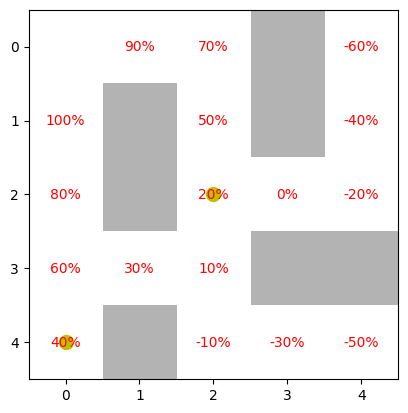

In [ ]:
# Define the grid, start position, and goal position
grid = [
    [0, 0, 0, 1, 0],
    [0, 1, 0, 1, 0],
    [0, 1, 0, 0, 0],
    [0, 0, 0, 1, 1],
    [0, 1, 0, 0, 0]
]
start = (0, 0)
goal = (4, 4)

# Environment and agent for Uniform Cost Search
environment_for_ucs = Environment(grid, start, goal)
agent_for_ucs = Agent(environment_for_ucs)

# Solving with UCS
solution_path_ucs, explored_paths_ucs = agent_for_ucs.uniform_cost_search()
recharge_count_ucs = environment_for_ucs.get_recharge_count()
print("UCS Solution Path:", solution_path_ucs)
print("UCS Recharge Count:", recharge_count_ucs)

# Environment and agent for A* algorithm
environment_for_astar = Environment(grid, start, goal)
agent_for_astar = Agent(environment_for_astar)

# Solving with A* algorithm
solution_path_astar, explored_paths_astar = agent_for_astar.a_star_search()
recharge_count_astar = environment_for_astar.get_recharge_count()
print("A* Solution Path:", solution_path_astar)
print("A* Recharge Count:", recharge_count_astar)

# Comparing efficiency
if solution_path_ucs and solution_path_astar:  # Check if solutions are found
    if recharge_count_ucs < recharge_count_astar:
        print("Uniform Cost Search is more efficient in terms of energy management.")
    elif recharge_count_astar < recharge_count_ucs:
        print("A* Search is more efficient in terms of energy management.")
    else:
        print("Both algorithms have the same efficiency in terms of energy management.")
else:
    print("One or both algorithms failed to find a solution.")

# Displaying the solution and explored paths if solutions are found
if solution_path_ucs:
    visualize_grid_and_path(grid, solution_path_ucs, explored_paths_ucs, [(2, 2), (4, 0)])  # Charging stations are at (2, 2) and (4, 0)
if solution_path_astar:
    visualize_grid_and_path(grid, solution_path_astar, explored_paths_astar, [(2, 2), (4, 0)])  # Charging stations are at (2, 2) and (4, 0)
